**Group Members**
1. **Trilokinath Modi**
2. **Linus Aronsson**
3. **Akshita Pingle**

**Assignment 2 Task 2**

# Basic setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [ ]:
from collections import Counter
import numpy as np
from spacy.lang.en import English
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib.ticker import MaxNLocator

nlp = English()

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
colWidth = pd.get_option('display.max_colwidth')

# Class and function definition

In [ ]:
class Corpus:
    def __init__(self, filePath, encoding, maxTokens):
        self.bagOfWords = Counter()
        self.listOfWords = ["removeMe"]  # So that the list is not empty
        self.wordInDocIndex = np.zeros(1, dtype=int)  # So that array is not empty
        self.docLen = list()
        self.numDocs = 0
        docNumber = 0
        numActualToken = 0
        fileHandler = open(filePath, encoding=encoding)
        with fileHandler:
            for doc in fileHandler:
                self.numDocs += 1
                tokens = doc.lower().split()
                numActualToken += len(tokens)
                numTokenTemp = 0
                for iToken in tokens:
                    if not nlp.vocab[iToken].is_stop and iToken not in ['.', '&', '...', '-', ';', '/', '!', ',', '(',
                                                                        ')', "'", '"', ':', "?",
                                                                        '....'] and not iToken.isdigit():
                        self.bagOfWords[iToken] += 1
                        self.listOfWords = self.listOfWords + [iToken]
                        numTokenTemp += 1
                self.docLen.append(numTokenTemp)
                tempArray = docNumber * np.ones(numTokenTemp, dtype=int)
                self.wordInDocIndex = np.concatenate((self.wordInDocIndex, tempArray), axis=None)
                docNumber += 1
                if numActualToken >= maxTokens + 1:
                    self.listOfWords.pop(0)  # Removed "removeMe"
                    self.wordInDocIndex = np.delete(self.wordInDocIndex, 0)
                    break
        fileHandler.close()

    def most_common_word(self, numOfMostCommonWords):
        self.corpusMostCommonWords = Counter(self.bagOfWords).most_common(numOfMostCommonWords)


class IntegerVocabulary:
    def __init__(self, mostCommonWords, maxVocabSize):
        self.integerVocab = dict()  # Changed from list to dict - See assignment 1
        wordCode = 0
        for iWord in range(maxVocabSize):
            self.integerVocab[mostCommonWords[iWord][0]] = wordCode
            wordCode += 1


In [ ]:
def estimateDocTopicProb(docId):
    numerator = docTopicFreq[docId] + topicParameter
    denominator = books.docLen[docId] - 1 + numTopics * topicParameter
    return numerator / denominator


def estimateTopicWordProb(wordIndex, prevWordIndex):
    numerator = bigramTopicFreq[wordIndex, prevWordIndex] + dirParameter
    sumWordsinToken = np.sum(wordTopicFreq, axis=0)
    denominator = sumWordsinToken + numUniqueWords * dirParameter
    return numerator / denominator


def estimateTopicWordProbUnPairedWords(wordIndex):  # The first words don't have preceeding word so this function is
    # picked from task 1 of this assignment.
    numerator = wordTopicFreq[wordIndex] + dirParameter
    sumWordsinToken = wordTopicFreq.sum(axis=0)
    denominator = sumWordsinToken + numUniqueWords * dirParameter  # Need to check if should be commented or included.
    return numerator / denominator

**Variable definition**

In [ ]:
filePath = "books.txt"
fileEncoding = "ISO-8859-1"

In [ ]:
maxGibbsIterations = 200
maxTokens = 100000
desiredWordsToBePrinted = 20

In [ ]:
books = Corpus(filePath, fileEncoding, maxTokens)
maxTokens = len(books.listOfWords)
numUniqueWords = len(books.bagOfWords)
numDocs = len(books.docLen)

maxVocabSize = numUniqueWords
numOfMostCommonWords = maxVocabSize  # Not considering padding and out-of-vocabulary - See assignment 1
books.most_common_word(numOfMostCommonWords)
booksIV = IntegerVocabulary(books.corpusMostCommonWords, maxVocabSize)

In [ ]:
# Task 2
documentTopicsDF = pd.DataFrame()
figureNum = 0
numTopicsList = [5, 10]
parameterList = [(0.1, 0.1), (0.01, 0.01)]

wordTopicResultsT2 = list()
sumWordsinTokenResultsT2 = list()

# Execution loop

In [ ]:
iCase = 0
for iTopicList in range(len(numTopicsList)):
    for iParameterList in range(len(parameterList)):
        print(iCase, end=" ")
        numTopics = numTopicsList[iTopicList]
        dirParameter = parameterList[iParameterList][0]
        topicParameter = parameterList[iParameterList][1]

        wordTopicResultsT2.append(list())
        sumWordsinTokenResultsT2.append(np.zeros(numTopics))

        # Random initialization matrix updates
        wordTopic = np.random.randint(0, numTopics, maxTokens)
        bigramTopicFreq = np.zeros((numUniqueWords, numUniqueWords, numTopics),
                                   dtype=int)  # This is transpose of what it suppose to be
        wordTopicFreq = np.zeros((numUniqueWords, numTopics), dtype=int)

        docId = np.arange(0, numDocs, 1)
        docTopicFreq = np.zeros((numDocs, numTopics), dtype=int)

        jDocId = 0
        for iNumber, iWord in enumerate(books.listOfWords):
            if iNumber > 0:
                wordIdentity = booksIV.integerVocab[iWord]
                prevWord = books.listOfWords[iNumber - 1]
                prevWordIdentity = booksIV.integerVocab[prevWord]
                jDocId = books.wordInDocIndex[iNumber]
                jDocIdPrevWord = books.wordInDocIndex[iNumber - 1]
                if jDocId == jDocIdPrevWord:
                    bigramTopicFreq[wordIdentity, prevWordIdentity, wordTopic[iNumber]] += 1
                    wordTopicFreq[wordIdentity, wordTopic[iNumber]] += 1
                    docTopicFreq[jDocId, wordTopic[iNumber]] += 1
                else:
                    wordTopicFreq[wordIdentity, wordTopic[iNumber]] += 1
                    docTopicFreq[jDocId, wordTopic[iNumber]] += 1
            else:
                wordIdentity = booksIV.integerVocab[iWord]
                wordTopicFreq[wordIdentity, wordTopic[iNumber]] += 1
                docTopicFreq[jDocId, wordTopic[iNumber]] += 1

        iGibbs = 0
        while iGibbs < maxGibbsIterations:
            iGibbs += 1
            iDocId = 0
            iDocIdPrevWord = 0
            for iNumber, iWord in enumerate(books.listOfWords):
                if iNumber > 0:
                    topicNumber = wordTopic[iNumber]
                    wordIdentity = booksIV.integerVocab[iWord]
                    prevWord = books.listOfWords[iNumber - 1]
                    prevWordIdentity = booksIV.integerVocab[prevWord]
                    iDocId = books.wordInDocIndex[iNumber]
                    iDocIdPrevWord = books.wordInDocIndex[iNumber - 1]
                    if iDocId == iDocIdPrevWord:
                        bigramTopicFreq[wordIdentity, prevWordIdentity, topicNumber] -= 1
                        wordTopicFreq[wordIdentity, topicNumber] -= 1
                        docTopicFreq[iDocId, topicNumber] -= 1
                        docTopicProb = estimateDocTopicProb(iDocId)
                        wordTopicProb = estimateTopicWordProb(wordIdentity,
                                                              prevWordIdentity)  # Notice, both are integer index
                        probWordInToken = np.multiply(docTopicProb, wordTopicProb)
                        selectedTopic = np.random.multinomial(1, probWordInToken / probWordInToken.sum()).argmax()
                        bigramTopicFreq[wordIdentity, prevWordIdentity, selectedTopic] += 1
                        docTopicFreq[iDocId, selectedTopic] += 1
                        wordTopicFreq[wordIdentity, selectedTopic] += 1
                        wordTopic[iNumber] = selectedTopic
                    else:  # Not necessary as only a few words will be affected.(The first word in every doc)
                        wordTopicFreq[wordIdentity, topicNumber] -= 1
                        docTopicFreq[iDocId, topicNumber] -= 1
                        docTopicProb = estimateDocTopicProb(iDocId)
                        wordTopicProb = estimateTopicWordProbUnPairedWords(
                            wordIdentity)  # First words are first word in each doc.
                        probWordInToken = np.multiply(docTopicProb, wordTopicProb)
                        selectedTopic = np.random.multinomial(1, probWordInToken / probWordInToken.sum()).argmax()
                        wordTopicFreq[booksIV.integerVocab[iWord], selectedTopic] += 1
                        docTopicFreq[iDocId, selectedTopic] += 1
                        wordTopic[iNumber] = selectedTopic
                else:  # This is only for first word in entire corpus. Not doing this shouldn't affect result at all. So
                    # this part can be skipped too
                    wordIdentity = booksIV.integerVocab[iWord]
                    topicNumber = wordTopic[iNumber]
                    wordTopicFreq[wordIdentity, topicNumber] -= 1
                    docTopicFreq[iDocId, topicNumber] -= 1
                    docTopicProb = estimateDocTopicProb(iDocId)
                    wordTopicProb = estimateTopicWordProbUnPairedWords(
                        wordIdentity)  # First words are first word in each doc.
                    probWordInToken = np.multiply(docTopicProb, wordTopicProb)
                    selectedTopic = np.random.multinomial(1, probWordInToken / probWordInToken.sum()).argmax()
                    wordTopicFreq[booksIV.integerVocab[iWord], selectedTopic] += 1
                    docTopicFreq[iDocId, selectedTopic] += 1
                    wordTopic[iNumber] = selectedTopic

        wordTopicResultsT2[iCase] = wordTopic
        sumWordsinTokenResultsT2[iCase] = wordTopicFreq.sum(axis=0)
        iCase += 1


0 1 2 3 

# Results

The next cell contains all the infomartion required to analyse results and draw conclusions. The cell contains 1 figure and 2 tables each for one of the 4 cases. The figure represents the fraction of words present in the topic as compared to total number of words considered for execution. The two tables represents words in each topic and words in the dominant topic of each document. Both the tables are trimmed to display 5 top topics and 15 documents respectively.

In general, the abstract format of output is figure, top 5 topics table and dominant topic in document table.

The table with top 5 topics portrays words that settled in topic by raw count, relative count and a mixture of raw and relative count. Raw count implies the words that are dominant within the topic, relative implies the words that are unique within corpus but ended under the highlighted topic and "relraw" implies the words first sorted based on raw count and then top 20 words were picked which were sorted by their relative count in the corpus. 

The table related to documents and dominant topic in the document goes through every document and looks for the topic that is dominant within the document and prints how much percentage of document exists in the topic and some of the words in this intersection. 

The observations are explained after printing all the outputs below.

Case 1, α = 0.10, β = 0.10, K = 5




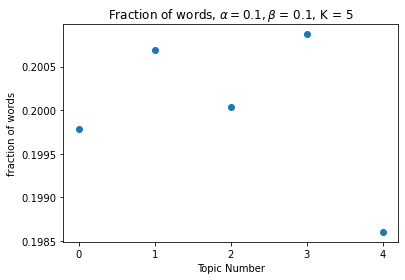

0          1           2             3              4  \
Topic 4 Raw          book       read       books       reading          novel   
        Rel          skip  terrorism         bin         laden       surround   
        RelRaw       home      novel   excellent          work          books   
Topic 0 Raw          book       read       great          like            sam   
        Rel          echo    avonlea   dominated  instrumental           w.c.   
        RelRaw        sam     family       great          love           want   
Topic 2 Raw          book       read       books          time           like   
        Rel        geared         ed       hearn          mets          teams   
        RelRaw    science        new      reader          best           time   
Topic 1 Raw          book       read       great          life           time   
        Rel     off-field       asna    men.well        runner        marches   
        RelRaw        war       work        find         great          found   
Topic 3 Raw          book       read        like          good        reading   
        Rel     mr.magnus     astral  projection        bogged  specificities   
        RelRaw        bob  recommend        know          like           good   

                         5               6            7             8  \
Topic 4 Raw           life            work        story          like   
        Rel       analyzes          larger      stinger      missiles   
        RelRaw     reading           years      written         world   
Topic 0 Raw           life           story         time          good   
        Rel          dance          foster    vaudville  orchestrated   
        RelRaw  characters       recommend        think          read   
Topic 2 Raw          story            best          new       reading   
        Rel         antics          locker      diehard   meaningless   
        RelRaw       books          author        story          find   
Topic 1 Raw           good            work        world           way   
        Rel          tunes  reconstruction     barbeque   whillingham   
        RelRaw     written           world          way          life   
Topic 3 Raw           life       recommend       people         story   
        Rel          lodge         seaward  comprehends        summed   
        RelRaw     history         reading        think        author   

                        9          10           11             12  \
Topic 4 Raw         world        good          way          years   
        Rel        bergen     mohamed    unnerving  egyptian-born   
        RelRaw        new        life          way          story   
Topic 0 Raw          love         way       family         people   
        Rel      preserve  recordings      compose        memphis   
        RelRaw       book       years          way           best   
Topic 2 Raw        people      author        great           work   
        Rel     reading.a      pagels  illustrator             cs   
        RelRaw    reading        like         book         people   
Topic 1 Raw        people       books         best          story   
        Rel           bbq     experts     darkness         browne   
        RelRaw       time        good          new           best   
Topic 3 Raw         books        know        great          world   
        Rel       carlson   reiterate  readability        focused   
        RelRaw     people        read         life        written   

                            13           14           15          16  \
Topic 4 Raw                new         time      written      people   
        Rel     middle-eastern    honorably   discharged      scores   
        RelRaw            best       people         good        read   
Topic 0 Raw               best        think    recommend       years   
        Rel              beale  entertainer     minstrel       orson   
        RelRaw       

,Document Number,Dominant Topic,Percentage,Words In Dominant Topic
356,356,0.0,1.0,"[exercises, book, purposefully, difficult, discourage, prospective, copyeditors, einsohn, years, experience, order, instructional, explanations, f..."
107,107,2.0,1.0,"[ann, rinaldi, book, read, impressed, like, ties, history, little, fiction, makes, great, story, come, alive, favorite, features, book, ending, ex..."
321,321,0.0,1.0,"[love, book, great, writing, lot, times, dostoevsky, gets, credit, crime, punishment, brothers, k, magnificent, peice, lit, definate, read]"
318,318,2.0,1.0,"[book, referred, friend, expected, language, easy, understand, flow, book, expect, embrace, knowledge, book, author, certainly, helps, past, knowl..."
310,310,3.0,1.0,"[loved, book, historical, references, tends, bring, story, life, relate, familiar, current, events, typical, hollywood, ending, good, ending, none..."
103,103,4.0,1.0,"[enjoyed, book, pictures, content, showing, different, reasons, people, locks, history, helps, appreciate, dreads, locs, called, different, cultur..."
104,104,1.0,1.0,"[genet, thief, journal, greatest, novel-if, whatyou, want, categorize, reason, greatest, book, wonderful, book, called, prisoner, love, knows, tur..."
106,106,4.0,1.0,"[long, desire, read, grisham, book, heard, good, things, chance, came, sorely, disappointed, audio, cd, sale, truck, stop, decided, chamber, openi..."
108,108,2.0,1.0,"[hugely, entertaining, start, finish, teacher, world, required, read, teacher, man]"
334,334,3.0,1.0,"[pipher, inspires, reader, write, writing, sake, difference, world, presents, thorough, examination, writing, process, reminding, perspectives, as..."





Case 2, α = 0.01, β = 0.01, K = 5




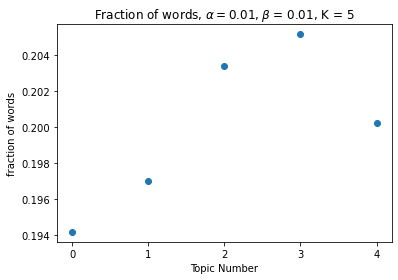

0               1            2           3  \
Topic 0 Raw              book            read        books        like   
        Rel     specificities            asna    dominated    men.well   
        RelRaw          books            work        years     writing   
Topic 1 Raw              book            read        great      people   
        Rel             scoop  conceptualized          gtr    eighties   
        RelRaw            sam         history         know      people   
Topic 4 Raw              book            read         time        good   
        Rel         terrorism             bin     analyzes     stinger   
        RelRaw           want          things         time       world   
Topic 2 Raw              book            read          way        like   
        Rel              echo           lodge      avonlea      geared   
        RelRaw         highly             way    recommend       found   
Topic 3 Raw              book            like         read       books   
        Rel         mr.magnus          astral   projection       realm   
        RelRaw            use             end  interesting  characters   

                            4        5         6             7              8  \
Topic 0 Raw             great  reading      work          life           good   
        Rel         reading.a   runner      kite         orson       algiere'   
        RelRaw            new     find   reading        author           like   
Topic 1 Raw               sam    story      know         world           life   
        Rel     competiveness  japense  supriour    succesfull     beautifull   
        RelRaw          think    found     great         world           read   
Topic 4 Raw             story     life     books        people          world   
        Rel          missiles      ali   mohamed     unnerving  egyptian-born   
        RelRaw           know   author      good          work        written   
Topic 2 Raw             great     time   reading          good            new   
        Rel              york       ed      skip         teams      off-field   
        RelRaw          years  written       new          read           book   
Topic 3 Raw              life    story      good         great           best   
        Rel            bogged     outs     hearn  peace-loving   non-muslim..   
        RelRaw           like   reader     books          best          think   

                             9         10                      11  \
Topic 0 Raw               time      years                     new   
        Rel              token       item  carry-on-to-the-heaven   
        RelRaw            love    written                    life   
Topic 1 Raw               good    reading                 history   
        Rel            affraid    japanse              industrial   
        RelRaw            work      story                  author   
Topic 4 Raw               like       best                   great   
        Rel     middle-eastern  honorably              discharged   
        RelRaw            best      story                  people   
Topic 2 Raw              story      world                    life   
        Rel             antics     locker                 diehard   
        RelRaw            time      world                   great   
Topic 3 Raw             people    reading                    time   
        Rel           regional    warlord               subjugate   
        RelRaw       recommend       know                    life   

                         12           13          14            15  \
Topic 0 Raw           story       author     writing          find   
        Rel        lonesome         dove      brules      parsifal   
        RelRaw        great         good        read          book   
Topic 1 Raw            like         time        work         think   
        Rel      engineerin     courtney        lied        addict   
        RelRaw       

,Document Number,Dominant Topic,Percentage,Words In Dominant Topic
581,581,3.0,1.0,"[title, implies, book, tries, answer, difficult, questions, christians, non-christians, people, ask, fate, world, approaching, end, times, prophes..."
433,433,2.0,1.0,"[small, significant, tome, clearly, outlines, think, thoughts, energy, forms, time, think, thought, generate, certain, type, frequency, follows, u..."
240,240,3.0,1.0,"[analytic, geometry, maths, student, encounters, combining, traditional, euclidean, geometry, algebra, profound, mix, students, wo, appreciate, bo..."
426,426,2.0,1.0,"[virginia, woolf, true, literary, genius, gift, capturing, emotional, lives, characters, seen, modern, writing, said, lighthouse, difficult, works..."
427,427,4.0,1.0,"[book, features, numerous, vignettes, grouped, themes, *, congratulations, life, *, internal, capabilities, understanding, life, potential, *, ext..."
429,429,0.0,1.0,"[case, book, buy, book, want, buy, long, questions, answer]"
235,235,2.0,1.0,"[book, outstanding, value, depth, knowledge, plenty, actionable, recommendation, like, consultants, matter.., shows, real, problems, opportunities..."
430,430,4.0,1.0,"[great, book, engineers, want, gain, basic, knowledge, explosives, book, detailed, chemical, descriptions, design, equations, valuable, book, espe..."
232,232,0.0,1.0,"[good, book, beginners, good, tips, advanced, watercolorists, valuable, additon, watercolor, library]"
231,231,0.0,1.0,"[book, fine, getting, idea, medieval, costume, looked, like, plan, use, source, historical, costume, research, illustrations, book, redrawings, no..."





Case 3, α = 0.10, β = 0.10, K = 10




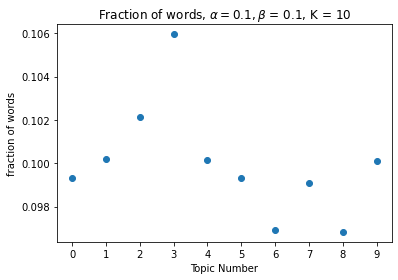

0          1            2             3  \
Topic 9 Raw             book       time        story          read   
        Rel          avonlea   missiles      terrain          blow   
        RelRaw         power      place         time           end   
Topic 4 Raw             book       like         read          good   
        Rel     instrumental    marches        dance         tunes   
        RelRaw           bob     school          lot    characters   
Topic 1 Raw             book       like         good          read   
        Rel             asna  imperious  re-readings  stupefyingly   
        RelRaw          help     family      writing        things   
Topic 2 Raw             book       read        great          like   
        Rel           geared         ed        hearn          mets   
        RelRaw          long        end         love         great   
Topic 3 Raw             book       read        books          good   
        Rel             outs       echo        lodge     dominated   
        RelRaw         books       read       author       written   

                          4            5               6             7  \
Topic 9 Raw            best         life             way        people   
        Rel         delving  antoinnette             xvi        regime   
        RelRaw        story         best            find         years   
Topic 4 Raw            time          bob            life    characters   
        Rel      recordings      compose  reconstruction      analyzes   
        RelRaw         want         love           novel          work   
Topic 1 Raw          people         time            work           way   
        Rel       strangely        upset    peace-loving  non-muslim..   
        RelRaw       people         find            good         think   
Topic 2 Raw            time         life           story          love   
        Rel          antics      diehard       life-like    phenomenal   
        RelRaw  interesting   characters            time          book   
Topic 3 Raw            like       author           great       written   
        Rel        men.well    reading.a          runner          kite   
        RelRaw       better      history            good       writing   

                            8              9          10            11  \
Topic 9 Raw              find          world       years          like   
        Rel         napoleons         lenins     stalins  predecessors   
        RelRaw          found            way       world          work   
Topic 4 Raw              work         school       story           way   
        Rel     egyptian-born  fragmentation     grandma         squid   
        RelRaw           good           time         way          like   
Topic 1 Raw             great        writing        life         think   
        Rel           warlord       spanning  scriptures        unholy   
        RelRaw           work            way       years          like   
Topic 2 Raw              best     characters     reading         world   
        Rel         vespatian        weaving   reinforce       warming   
        RelRaw          think           read        life     recommend   
Topic 3 Raw             world           life       think       reading   
        Rel       whillingham            bbq       orson      algiere'   
        RelRaw          think           book        know          want   

                       12         13          14                      15  \
Topic 9 Raw         found       work        good                 reading   
        Rel        coelho        rio     janeiro               d'honneur   
        RelRaw       life     people     reading                    good   
Topic 4 Raw          love       want      people                     lot   
        Rel     texturing     benson        cram               extension   
        RelRaw        new       life        best                  people   
Topi

,Document Number,Dominant Topic,Percentage,Words In Dominant Topic
453,453,2.0,1.0,"[book, great, book, read, good, young, teens, book, real, peaceful, painful, earth, life, lessons, instantly, fell, love, book, dad, mom, care, br..."
23,23,2.0,1.0,"[nora, garden, trilogy, great, best, characters, life-like, actually, feel, like, story, phenomenal, author, come, thoroughly, enjoyed, highly, re..."
55,55,2.0,1.0,"[kept, series, amused, touched, birth, mavis, baby, ending, brings, tear, especially, gone, process', eve, roarke, reactions, downright, funny, ri..."
203,203,3.0,1.0,"[picked, book, idea, expect, thought, long, stuffy, like, books, genere, mildly, entertaining, surprise, writing, crisp, engaging, imaginative, am..."
361,361,2.0,1.0,"[great, book, wise, author, willard, best, comes, spiritual, growth, discipleship]"
208,208,2.0,1.0,"[looking, lot, information, ebay, place, pretty, good, agree, previous, poster, said, bit, disjointed, example, complete, story, christian, woman,..."
103,103,7.0,1.0,"[enjoyed, book, pictures, content, showing, different, reasons, people, locks, history, helps, appreciate, dreads, locs, called, different, cultur..."
508,508,6.0,1.0,"[meat, area, reading, lot, miscellaneous, information]"
100,100,4.0,1.0,"[attended, lecture, given, dr., wilkins, 8th, edition, text, autographed, vivacious, wonderful, woman, gave, refresher, needed, book, wonderful, m..."
554,554,9.0,1.0,"[travel, ny, time, great, shipped, fast]"





Case 4, α = 0.01, β = 0.01, K = 10




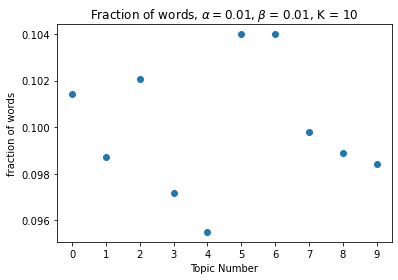

0            1               2            3  \
Topic 7 Raw           book         life           books         best   
        Rel        marches        beale  conceptualized          gtr   
        RelRaw   character      written           novel         best   
Topic 0 Raw           book         read       recommend        great   
        Rel      mr.magnus   projection           lodge      avonlea   
        RelRaw     edition       highly            easy    recommend   
Topic 2 Raw           book         like           great        novel   
        Rel        seaward  comprehends             wry  re-readings   
        RelRaw      modern        right           novel       things   
Topic 5 Raw           book         read             sam         like   
        Rel     phenomenal    supported          gables          sat   
        RelRaw   guralnick        cooke       biography          sam   
Topic 6 Raw           book         read           great         like   
        Rel           echo   transition        surround      stinger   
        RelRaw         mr.         look            love    excellent   

                          4              5          6            7  \
Topic 7 Raw           story           read    written        novel   
        Rel     catagorized          paulo     coelho          rio   
        RelRaw      writing          think    history         life   
Topic 0 Raw            like           life      years         good   
        Rel            asna      dominated   men.well    reading.a   
        RelRaw       family           look      years       things   
Topic 2 Raw           story          world     people         good   
        Rel      tangential   stupefyingly  strangely        kelby   
        RelRaw  interesting          world      found   characters   
Topic 5 Raw            life          story       time      reading   
        Rel         weaving      reinforce    warming    persuaded   
        RelRaw         john          makes        end  interesting   
Topic 6 Raw           story           love      world        books   
        Rel        missiles  egyptian-born     scores     paradigm   
        RelRaw         real          great       know      writing   

                               8              9          10        11  \
Topic 7 Raw                 time          world        work       way   
        Rel              janeiro        awarded   d'honneur  grinzane   
        RelRaw              work          books       world     story   
Topic 0 Raw                  way         family        time    people   
        Rel                 jazz   instrumental        w.c.     dance   
        RelRaw              read         little         way     great   
Topic 2 Raw                 read           life        work      time   
        Rel     well-established        lightly  tv-channel    evolve   
        RelRaw              work         people       story     great   
Topic 5 Raw            guralnick          cooke       great       end   
        Rel                  ddt        hazards    silicone    breast   
        RelRaw            little           like        read      life   
Topic 6 Raw                 know           time         mr.      real   
        Rel             eighties  competiveness     japense  supriour   
        RelRaw              book           read       story     world   

                                12          13            14             15  \
Topic 7 Raw                 people        good         think      character   
        Rel                 cavour    inducted     brazilian          2002.   
        RelRaw                 way         new        author         people   
Topic 0 Raw                 highly      things         books         little   
        Rel              vaudville       tunes  orchestrated       preserve   
        RelRaw                life        like          book           good   
Topic 2 Raw                  

,Document Number,Dominant Topic,Percentage,Words In Dominant Topic
235,235,5.0,1.0,"[book, outstanding, value, depth, knowledge, plenty, actionable, recommendation, like, consultants, matter.., shows, real, problems, opportunities..."
527,527,6.0,1.0,"[wonderful, book, combining, humor, sensitive, philosophical, look, humans, laughed, cried, listened]"
275,275,0.0,1.0,"[book, lipstick, jihad, azadeh, moaveni, interesting, factual, book, tells, story, person, iranian, girl, living, america, college, moving, iran, ..."
523,523,0.0,1.0,"[book, based, secondary, sources, fine, job, describing, past, years, arab, fight, jewish, rights, excellent, introduction, arab-israeli, conflict..."
270,270,3.0,1.0,"[book, helped, understand, things, going, cope, hard, time, living, daughter, book, makes, easier, quick, fix, it...but, book, ways, hows, whys, f..."
268,268,6.0,1.0,"[pre-ordered, book, amazon, soon, read, exhibit, whitney, ths, book, wonderful, compendium, art, 20th, century, loaded, information, great, photos..."
267,267,6.0,1.0,"[great, book, read, great, teaching, tool, know, long, took, complete, dad, wrote]"
264,264,4.0,1.0,"[outline, covers, applied, mathematics, upper, level, undergraduate, graduate, engineers, need, know, solve, problems, great, reference, scope, br..."
260,260,1.0,1.0,"[page, page, perfect, book, non-writing, writer, person, continually, dreams, writing, manages, words, page, past, false, starts, heather, sellers..."
257,257,4.0,1.0,"[found, roger, jahnke, book, healer, absolutely, fantastic, circle, answers, definatly, half, reading, book, stregth, self, esteem, matters, hands..."


In [ ]:
# Results
topTopicsSize = 5
iCase = 0
for iTopicList in range(len(numTopicsList)):
    for iParameterList in range(len(parameterList)):
        numTopics = numTopicsList[iTopicList]
        dirParameter = parameterList[iParameterList][0]
        topicParameter = parameterList[iParameterList][1]

        print("Case %d, \u03B1 = %.2f, \u03B2 = %.2f, K = %d\n\n" % (iCase + 1, topicParameter, dirParameter, numTopics))

        # Result part - 1. Plots
        sumWordsinToken = sumWordsinTokenResultsT2[iCase].copy()
        figureNum += 1
        ax = plt.figure(figureNum).gca()
        plt.scatter(np.arange(0, numTopics), sumWordsinToken / maxTokens)
        plt.xlabel("Topic Number")
        plt.ylabel("fraction of words")
        plt.title(r"Fraction of words, $\alpha = {}, \beta$ = {}, K = {}".format(str(topicParameter), str(dirParameter),
                                                                                 str(numTopics)))
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.show()

        # Result part - 2
        topicWordRelationByRawCount = list()
        topicWordRelationByRelativeCount = list()
        topicWordRelationByRelInMaxRaw = list()
        for iTopic in range(numTopics):
            topicWordRelationByRawCount.append(Counter())
            topicWordRelationByRelInMaxRaw.append(Counter())

        for iNumber, iWord in enumerate(books.listOfWords):
            topicWordRelationByRawCount[wordTopicResultsT2[iCase][iNumber]][iWord] += 1

        for iTopic in range(numTopics):
            topicWordRelationByRelativeCount.append(topicWordRelationByRawCount[iTopic].copy())

        for iTopic in range(numTopics):
            for iWord in topicWordRelationByRawCount[iTopic].keys():
                temp = topicWordRelationByRawCount[iTopic][iWord]
                topicWordRelationByRelativeCount[iTopic][iWord] = temp / books.bagOfWords[
                    iWord]

        for iTopic in range(numTopics):
            tempDict = [topicWordRelationByRawCount[iTopic], topicWordRelationByRelativeCount[iTopic]]
            for iWord in topicWordRelationByRawCount[iTopic].keys():
                topicWordRelationByRelInMaxRaw[iTopic][iWord] = tuple(i[iWord] for i in tempDict)

        backupRel = list()
        for iTopic in range(numTopics):
            backupRel.append(topicWordRelationByRelativeCount[iTopic].copy())

        for iTopic in range(numTopics):
            topicWordRelationByRawCount[iTopic] = sorted(topicWordRelationByRawCount[iTopic].items(),
                                                         key=lambda x: x[1],
                                                         reverse=True)
            topicWordRelationByRelativeCount[iTopic] = sorted(topicWordRelationByRelativeCount[iTopic].items(),
                                                              key=lambda x: x[1], reverse=True)
            topicWordRelationByRelInMaxRaw[iTopic] = sorted(topicWordRelationByRelInMaxRaw[iTopic].items(),
                                                            key=lambda x: x[1][0], reverse=True)

        maxWordsCanBePrinted = list()
        for iMax in range(numTopics):
            maxWordsCanBePrinted.append(len(topicWordRelationByRawCount[iMax]))

        numWordsToPrint = list()
        for iMin in range(numTopics):
            numWordsToPrint.append(min(maxWordsCanBePrinted[iMin], desiredWordsToBePrinted))
            topicWordRelationByRelInMaxRaw[iMin] = topicWordRelationByRelInMaxRaw[iMin][:numWordsToPrint[iMin]]
            topicWordRelationByRelInMaxRaw[iMin] = sorted(topicWordRelationByRelInMaxRaw[iMin],
                                                          key=lambda x: x[1][1], reverse=True)

        uniqueWordsinToken = [len(topicWordRelationByRelativeCount[iTopic]) for iTopic in range(numTopics)]
        uniqueWordsinToken = np.array(uniqueWordsinToken)

        topTopics = sumWordsinToken.argsort()[numTopics - topTopicsSize:]
        listHeader = ["removeMe"]
        for i in range(len(topTopics)):
            listHeader = listHeader + ["Topic {}".format(topTopics[i])]
        listHeader.pop(0)
        colHeaders = pd.MultiIndex.from_product([listHeader, ['Raw', 'Rel', 'RelRaw']])
        resultTopicDF = pd.DataFrame()
        # for iDFRow in range(min(numWordsToPrint)): # For all topics
        for iDFRow in range(desiredWordsToBePrinted):
            tempRow = list()
            for iDFCell in range(len(topTopics)):
                try:
                    tempRow.append(topicWordRelationByRawCount[topTopics[iDFCell]][iDFRow][0])
                except:
                    tempRow.append("NA")
                try:
                    tempRow.append(topicWordRelationByRelativeCount[topTopics[iDFCell]][iDFRow][0])
                except:
                    tempRow.append("NA")
                try:
                    tempRow.append(topicWordRelationByRelInMaxRaw[topTopics[iDFCell]][iDFRow][0])
                except:
                    tempRow.append("NA")
            tempDF = pd.DataFrame([tempRow])
            if len(tempRow) > 0:
                resultTopicDF = resultTopicDF.append(tempDF, ignore_index=True)
            tempRow.clear()
        resultTopicDF.columns = colHeaders
        display(resultTopicDF.head(desiredWordsToBePrinted).transpose())

        print("\n\n")

        # Result part - 3. Works fine(Hopefully)
        topicCount = list()
        topicCountPerc = list()
        maxTopicNumPerc = np.zeros((numDocs, 2), dtype=float)
        wordsInMaxTopic = list()
        iPosition = 0
        jPosition = 0
        for iDoc in range(numDocs):
            topicCountPerc.append(np.zeros(numTopics, dtype=float))
            topicCount.append(np.zeros(numTopics, dtype=int))
            wordsInMaxTopic.append(list())

            for iWord in range(jPosition, jPosition + books.docLen[iDoc]):
                topicCount[iDoc][wordTopicResultsT2[iCase][iWord]] += 1
            jPosition += books.docLen[iDoc]
            topicCountPerc[iDoc] = topicCount[iDoc] / books.docLen[iDoc]

            maxTopicNumPerc[iDoc][0] = int(topicCount[iDoc].argmax())
            maxTopicNumPerc[iDoc][1] = max(topicCountPerc[iDoc])

            for iWord in range(iPosition, iPosition + books.docLen[iDoc]):
                if wordTopicResultsT2[iCase][iWord] == maxTopicNumPerc[iDoc][0]:
                    wordsInMaxTopic[iDoc].append(books.listOfWords[iWord])
            iPosition += books.docLen[iDoc]

        documentTopicsDF = pd.DataFrame()

        documentTopicsDF.insert(0, "Document Number", np.arange(0, numDocs, 1))
        documentTopicsDF.insert(1, "Dominant Topic", maxTopicNumPerc[:, 0])
        documentTopicsDF.insert(2, "Percentage", maxTopicNumPerc[:, 1])
        documentTopicsDF.insert(3, "Words In Dominant Topic", wordsInMaxTopic)
        documentTopicsDF = documentTopicsDF.sort_values("Percentage", ascending=False)
        pd.set_option('display.max_colwidth', 150)
        documentTopicsDF.style.hide_index()
        display(documentTopicsDF.head(15))
        pd.set_option('display.max_colwidth', colWidth)
        
        print("\n\n")
        iCase += 1


# Inferences

The inferences can be made are as follows:
1.  The distribution of words in each topic is much more uniform as compared to task 1. This may indicate that the words were assigned to various topics with low confidence. 
2.  Words in majority of dominant topics appears to be adjectives. Since the algorithm considers a bigram of words, it can be argued that such a case may arise. For certain topics, clear meanings were observed.
3.  The document table can summarise well about the reviews shared in the document. 

For example, In case 3 the following topics conveys, 

Topic | Meaning | Relation
--- | --- | ---
9 | History | ***
4 | Music and Dance | ***
1 | Religion | **
2 | Grooming | *
3 | Generic | *

It can also be noted that that common adjectives like *best, great, real, excellent, fantastic* etc are predominant and adjectives like *exceptional, stupefyingly, upset* etc rarely used adjectives are also present but in less frequency. 

Some hints related to type of document can be made in many cases. For exmaple, in case 4, table 2 it is clear that the document 264 contains mathematical academic book and has received positive reviews. Such specific instances can be found more, for example - religion and gender in doc 523 and art related in doc 268 etc.

Comparing to task 1, we can say that the general meaning of each topic is better conveyed in task 1 i.e. LDA, but the type of review for documents is better clustered in task 2. Hyperparameter tuning can be done to achieve better results which is also the maximization step in EM algorithm. 